# Wikipedia Talk Data - Getting Started

This notebook gives an introduction to working with the various data sets in [Wikipedia
Talk](https://figshare.com/projects/Wikipedia_Talk/16731) project on Figshare. The release includes:

1. a large historical corpus of discussion comments on Wikipedia talk pages
2. a sample of over 100k comments with human labels for whether the comment contains a personal attack
3. a sample of over 100k comments with human labels for whether the comment has aggressive tone

Please refer to our [wiki](https://meta.wikimedia.org/wiki/Research:Detox/Data_Release) for documentation of the schema of each data set and our [research paper](https://arxiv.org/abs/1610.08914) for documentation on the data collection and modeling methodology. 

In this notebook we show how to build a simple classifier for detecting personal attacks and apply the classifier to a random sample of the comment corpus to see whether discussions on user pages have more personal attacks than discussion on article pages.

## Building a classifier for personal attacks
In this section we will train a simple bag-of-words classifier for personal attacks using the [Wikipedia Talk Labels: Personal Attacks]() data set.

In [1]:
import pandas as pd
import urllib
import string
import re
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [2]:
# download annotated comments and annotations

ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7554634' 
ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7554637' 

def download_file(url, fname):
    urllib.request.urlretrieve(url, fname)

# You can edit the code here to download only once, and not download it later                
download_file(ANNOTATED_COMMENTS_URL, 'attack_annotated_comments.tsv')
download_file(ANNOTATIONS_URL, 'attack_annotations.tsv')

In [3]:
comments = pd.read_csv('attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('attack_annotations.tsv',  sep = '\t')

In [4]:
len(annotations['rev_id'].unique())

115864

In [5]:
# labels a comment as an atack if the majority of annotators did so
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5

In [6]:
# join labels and comments
comments['attack'] = labels

# Visualize Data

In [7]:
comments.keys()

Index(['comment', 'year', 'logged_in', 'ns', 'sample', 'split', 'attack'], dtype='object')

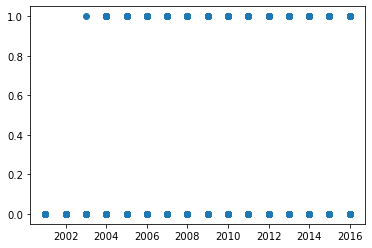

In [8]:
# Visualize
plt.scatter(comments['year'], comments['attack'])

In [9]:
comments['attack'].size

115864

# Data Cleanup

In [10]:
# remove comments with no recorded attacks
comments = comments.query("year>=2003")

In [11]:
# remove newline and tab tokens
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

In [12]:
# Check removal
comments.head(10)

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
554005,The references to the Congolese economy se...,2003,True,user,random,train,False
569192,"` I cut the following paragraph, which misle...",2003,True,article,random,train,False
583986,"Dear Mav: Thanks, bro! God bless you! Since...",2003,True,user,random,train,False
593977,"` That's true. I removed similar passages, wh...",2003,True,article,random,test,False
600918,"` :Yes, thanks! I have implemented something ...",2003,True,user,random,train,False
622095,`This page is ridiculous. The author throws i...,2003,True,article,random,test,False
633526,```2000's: The Jewish blood-libel myth continu...,2003,True,article,random,train,False
661509,MarcusAurelius]] Why exactly was this user b...,2003,False,user,blocked,train,False
680470,There is no such thing as Christian religiocen...,2003,True,article,random,train,False


In [13]:
# Additional text cleanup (lowercase, punctuations, numbers)
comments['comment'] = comments['comment'].apply(lambda x: x.lower())
comments['comment'] = comments['comment'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), " ", x))
comments['comment'] = comments['comment'].apply(lambda x: re.sub('\w*\d\w*', " ", x))


In [14]:
# check cleanup
comments.head(10)

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
554005,the references to the congolese economy se...,2003,True,user,random,train,False
569192,i cut the following paragraph which misle...,2003,True,article,random,train,False
583986,dear mav thanks bro god bless you since...,2003,True,user,random,train,False
593977,that s true i removed similar passages wh...,2003,True,article,random,test,False
600918,yes thanks i have implemented something ...,2003,True,user,random,train,False
622095,this page is ridiculous the author throws i...,2003,True,article,random,test,False
633526,s the jewish blood libel myth continues ...,2003,True,article,random,train,False
661509,marcusaurelius why exactly was this user b...,2003,False,user,blocked,train,False
680470,there is no such thing as christian religiocen...,2003,True,article,random,train,False


In [15]:
# check cleanup on attack comments
comments.query('attack')['comment'].head(10)

rev_id
801279             iraq is not good            usa is bad   
2702703           fuck off you little asshole  if you wan...
4632658         i have a dick  its bigger than yours  hahaha
6545332         renault     you sad little bpy for drivin...
6545351         renault     you sad little bo for driving...
7977970         nov    utc     because you like to accuse...
8359431         you are not worth the effort  you are arg...
8724028    yes  complain to your rabbi and then go shoot ...
8845700                     i am using the sandbox  ass wipe
8845736         god damn     god damn it fuckers  i am us...
Name: comment, dtype: object

# Model Building

In [16]:
from sklearn.model_selection import train_test_split
# Cross-validation (test = .3, train = .7 (complimentary))
train_comments, test_comments = train_test_split(comments, test_size = 0.3)

In [17]:
# from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
# fit a simple text classifier

estimators = [    
    ('vect', TfidfVectorizer(max_features = 10000, 
                             analyzer = 'word', 
                             ngram_range = (1,2), 
                             stop_words='english'
                            )),
    ('clf', LinearSVC(penalty='l2',
                      loss='squared_hinge', 
                      dual=False, 
                      tol=0.0001, 
                      C=1.0, 
                      multi_class='ovr', 
                      fit_intercept=True, 
                      intercept_scaling=1, 
                      class_weight=None, 
                      verbose=0, 
                      random_state=5, 
                      max_iter=10000
                     ))
]

clf = Pipeline(estimators)

In [18]:
clf = clf.fit(train_comments['comment'], train_comments['attack'])
met = metrics.classification_report(test_comments['attack'], clf.predict(test_comments['comment']))

# Results

In [19]:
print(met)

              precision    recall  f1-score   support

       False       0.95      0.99      0.97     30722
        True       0.85      0.64      0.73      4021

    accuracy                           0.95     34743
   macro avg       0.90      0.81      0.85     34743
weighted avg       0.94      0.95      0.94     34743



In [20]:
from sklearn.metrics import confusion_matrix

# add confusion matrix
confusion_matrix(test_comments['attack'], clf.predict(test_comments['comment']), normalize = 'pred')

array([[0.95480066, 0.14840408],
       [0.04519934, 0.85159592]])

In [21]:
# correctly classify nice comment
clf.predict(['Thanks for you contribution, you did a great job!'])

array([False])

In [22]:
# correctly classify nasty comment
clf.predict(['People as stupid as you should not edit Wikipedia!'])

array([ True])

In [41]:
clf.predict(['i like you'])

array([False])

# Questions
a. What text cleaning methods did you try? Which are the ones you included in the final code?
    - Filter out stop words via TfidfVectorizer(stop_words='english')
	- Lowercase all text
    - Remove numbers
    - Remove punctuations
    
b. What are the features you considered using? Which features did you use in the final code?
    - Tried Unigrams, Bigrams, Both; analyzing words
	- chars with ngram 1-5 but memory filled up; author suggested this was the best approach but I was not able to reproduce results.
    - Stop words via TfidfVectorizer(stop_words='english')
    
c. How did you decide to use the ‘attack’ information from different annotators? Did you average them, or use a number threshold, or did you use some other method to use this information?
    - Manipulating the labels mean() to be less than majority or greater than majority effected the f1 scores such that further deviation away from labels mean() > 0.5 resulted in decreasing the f1-score for correctly classifying nasty comments. However, increasing the threshold improves the f1-score for correctly classifying nice comments as "false" and ultimately improved thed weighted average f1 score. Therefore, I felt it more appropriate to maximize the correct classification for nast comments as this is more of the general purpose for this classifier.     
    
d. What optimizations did you add in your code, if any?
	- Removed comments before 2003, there were no recorded attacks; approximately 8 comments, did not significantly affect results whatsoever
    - Use of stopwords

e. What are the ML methods you tried out, and what were your best results with each method? Which was the best ML method you saw before tuning hyperparameters?
    - LogisticRegression (Second best)
    - MultinomialNB (Naieve Bayes)
    - LinearSVC(Best results)
    Tuning hyperparameters for LinearSVC did not significantly improve my results.
    
f. What hyper-parameter tuning did you do, and by how many percentage points did your accuracy go up because of hyper-parameter tuning?
     - A slight increase of 1% is seen in our True precision, but this could be from a randomized state computation of our data. Accuracy did not change from 0.94 overall.

g. What did you learn from the different metrics? Did you try cross-validation?
    - From the metrics, it seems that our data strongly supports classifying nice comments. This makes sense since supporting comments(30k) are about 7x more evident than nasty comments(4k) in our processed and pipelined dataset. I was unable to try cross-validation, but I did try to implement a train_test_split using test = 0.3 and complimentary train = 0.7. The accuracy started at 0.91

h. What are your best final Result Metrics? What is the increase in accuracy compared to the strawman figure? Which model gave you this performance?
    - My best final result metric was getting the True f1-score above 0.7 which started from the strawman True f1-score of 0.63. This was acchieved using LinearSVC with default parameters
    
i. What is the most interesting thing you learned from doing the report?
    -I really enjoyed working in jupyter. It's particularly interesting how reports in jupyter literally feels like reading a journal entry or report, rather than code structures formatted in an IDE. 

j. What was the hardest thing to do?
    - Reading all the documentation for sklearn libraries. Theres so much to learn and improve!
